In [1]:
import os

os.chdir('../..')

In [2]:
from itertools import combinations
from os.path import join

import numpy as np
import pandas as pd

from numpy.linalg import norm

import modules.point_processing as pp

In [13]:
trial_name = '2014-12-03_P005_Post_002'
# trial_name = '2014-12-03_P007_Post_000'

best_pos_dir = join('data', 'kinect', 'best_pos')
hypo_dir = join('data', 'kinect', 'processed', 'hypothesis')
align_dir = join('data', 'kinect', 'labelled_trials', 'alignment')

df_truth = pd.read_pickle(join('results', 'dataframes', 'df_truth.pkl'))

# Selected head and foot positions in trial
df_selected = pd.read_pickle(join(best_pos_dir, trial_name) + '.pkl')

# True head and foot positions in trial
df_truth_trial = df_truth.loc[trial_name][df_selected.columns]

# Position hypotheses (joint proposals)
df_hypo = pd.read_pickle(join(hypo_dir, trial_name) + '.pkl')

# Used to align image file numbers and frame numbers
df_align = pd.read_csv(
    join(align_dir, trial_name + '.txt'),
    header=None,
    names=['image_file'])

# Extract number from image file name
pattern = r'(\d+)\.png'
df_align['image_number'] = df_align.image_file.str.extract(pattern)

df_align = df_align.dropna()
df_align.image_number = pd.to_numeric(df_align.image_number)

df_hypo['image_number'] = df_align.image_number
df_hypo = df_hypo.set_index('image_number')

# Change index of selected positions to be the
# image numbers from the labelled trials.
# This allows for alignment with the ground truth
df_selected['image_number'] = df_align.image_number
df_selected = df_selected.set_index('image_number')

df_compare = pd.concat(
    {
        'Selected': df_selected,
        'Truth': df_truth_trial,
        'Hypotheses': df_hypo,
    }, axis=1).dropna()

image_frames = df_compare.index.values

# %% Compute modified truth (best pair of hypotheses)

# grouped_hypotheses = df_compare.Hypotheses.apply(
#     lambda x: np.vstack((x.L_FOOT, x.R_FOOT)), axis=1)

df_truth_modified = pd.DataFrame(
    index=image_frames, columns=['L_FOOT', 'R_FOOT'])

for frame, points_hypo in df_compare.Hypotheses.FOOT.items():

    truth_points = np.stack(
        df_compare.Truth.loc[frame][['L_FOOT', 'R_FOOT']])
    pairs = list(combinations(points_hypo, 2))

    costs = np.zeros(len(pairs))
    pairs_assigned = []

    for i, pair in enumerate(pairs):

        # Assign points in pair to the two truth points
        pair_assigned = pp.correspond_points(truth_points, pair)

        pairs_assigned.append(pair_assigned)

        costs[i] = np.apply_along_axis(norm, 1,
                                       pair_assigned - truth_points).sum()

    best_pair = pairs_assigned[np.argmin(costs)]

    df_truth_modified.loc[frame].L_FOOT = best_pair[0]
    df_truth_modified.loc[frame].R_FOOT = best_pair[1]

max_dist = 15

within_dist = pd.Series(index=image_frames)
error_list = []

for frame, row in df_compare.iterrows():

    selected_l, selected_r = row.Selected[['L_FOOT', 'R_FOOT']]
    true_l, true_r = df_truth_modified.loc[frame][['L_FOOT', 'R_FOOT']]

    points_selected = np.stack((selected_l, selected_r))
    points_true = np.stack((true_l, true_r))

    points_assigned = pp.correspond_points(points_true, points_selected)
    dists = np.apply_along_axis(norm, 1, points_assigned - points_true)

    within_dist.loc[frame] = norm(row.Selected.HEAD - df_truth_trial.loc[frame].HEAD) < max_dist
#     within_dist.loc[frame] = np.all(dists < max_dist)
    error_list.append(np.sum(dists))

accuracy = within_dist.value_counts(normalize=True)[True]

print("""
Error: {}\n
Accuracy: {}""".format(np.mean(error_list), accuracy))


Error: 55.56527866817194

Accuracy: 1.0


In [16]:
import matplotlib.pyplot as plt

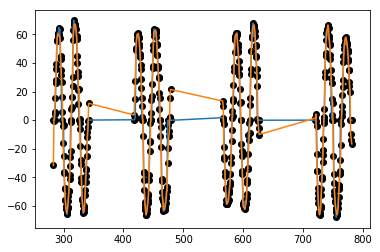

In [17]:
plt.figure()

vectors = np.stack(df_truth_modified.apply(lambda x: x.L_FOOT - x.R_FOOT, axis=1))
dot_prods = np.apply_along_axis(np.dot, 1, vectors, [1, 0, 0])

plt.scatter(image_frames, dot_prods, c='k')
plt.plot(image_frames, dot_prods)

vectors = np.stack(df_compare.Truth.apply(lambda x: x.L_FOOT - x.R_FOOT, axis=1))
dot_prods = np.apply_along_axis(np.dot, 1, vectors, [1, 0, 0])

plt.scatter(image_frames, dot_prods, c='k')
plt.plot(image_frames, dot_prods)

plt.show()

#### 